In [1]:
import pandas as pd
import io
import requests
from IPython.core.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

pd.options.display.max_columns = 50

In [2]:
# get sample data
# for CSV
url_data = "http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/diabetes.csv"
r = requests.get(url_data).content
df = pd.read_csv(io.StringIO(r.decode('utf-8')))
df.head(10)

,id,chol,stab.glu,hdl,ratio,glyhb,location,age,gender,height,weight,frame,bp.1s,bp.1d,bp.2s,bp.2d,waist,hip,time.ppn
0,1000,203.0,82,56.0,3.6,4.31,Buckingham,46,female,62.0,121.0,medium,118.0,59.0,NaN,NaN,29.0,38.0,720.0
1,1001,165.0,97,24.0,6.9,4.44,Buckingham,29,female,64.0,218.0,large,112.0,68.0,NaN,NaN,46.0,48.0,360.0
2,1002,228.0,92,37.0,6.2,4.64,Buckingham,58,female,61.0,256.0,large,190.0,92.0,185.0,92.0,49.0,57.0,180.0
3,1003,78.0,93,12.0,6.5,4.63,Buckingham,67,male,67.0,119.0,large,110.0,50.0,NaN,NaN,33.0,38.0,480.0
4,1005,249.0,90,28.0,8.9,7.72,Buckingham,64,male,68.0,183.0,medium,138.0,80.0,NaN,NaN,44.0,41.0,300.0
5,1008,248.0,94,69.0,3.6,4.81,Buckingham,34,male,71.0,190.0,large,132.0,86.0,NaN,NaN,36.0,42.0,195.0
6,1011,195.0,92,41.0,4.8,4.84,Buckingham,30,male,69.0,191.0,medium,161.0,112.0,161.0,112.0,46.0,49.0,720.0
7,1015,227.0,75,44.0,5.2,3.94,Buckingham,37,male,59.0,170.0,medium,NaN,NaN,NaN,NaN,34.0,39.0,1020.0
8,1016,177.0,87,49.0,3.6,4.84,Buckingham,45,male,69.0,166.0,large,160.0,80.0,128.0,86.0,34.0,40.0,300.0
9,1022,263.0,89,40.0,6.6,5.78,Buckingham,55,female,63.0,202.0,small,108.0,72.0,NaN,NaN,45.0,50.0,240.0


bp.1s and bp.2s are systolic blood pressure measurements taken from the same individual 10 minutes apart. There should be little difference in the measurements, since the time difference from which they are taken is so small. However, let's test that using a **paired, two sample t-test**.

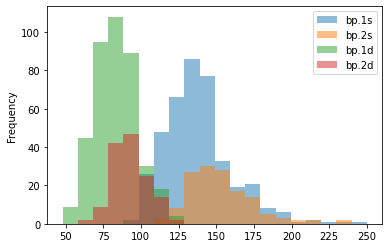

In [26]:
df[['bp.1s','bp.2s','bp.1d','bp.2d']].plot.hist(alpha=0.5, bins=20);

In [47]:
from scipy.stats import ttest_rel
dft = df[['bp.1s','bp.2s']].dropna(how='any')

a = dft['bp.1s'].values
b = dft['bp.2s'].values

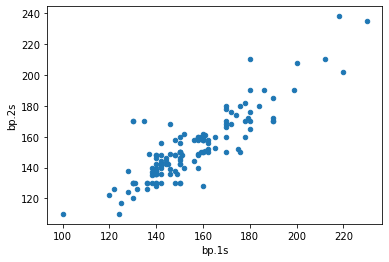

In [48]:
dft.plot.scatter(x='bp.1s', y='bp.2s');

In [49]:
print(a.mean(), a.std())
print(b.mean(), b.std())

154.75886524822695 20.755209790896153
152.38297872340425 21.63581859894272


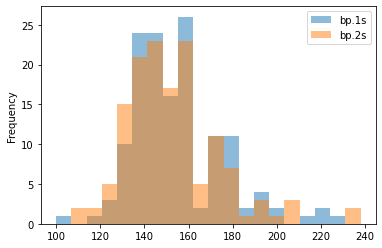

In [50]:
# first let's plot a histogram to get a sense of the scale
import seaborn as sns
dft.plot.hist(alpha=0.5, bins=20);
plt.legend();

In [51]:
n_samples = len(dft)
print(n_samples)

141


141 samples so the CLT should hold for this sample set. 

In [52]:
statistic, pvalue = ttest_rel(a, b)
print(statistic, pvalue)

2.581007266995989 0.01087975189907892


In [53]:
two_sided_pvalue = pvalue * 2
print(two_sided_pvalue)

0.02175950379815784


p < 0.05, so these results are significant, and we can reject the Null hypothesis that there is no difference in the blood pressure measurements, and **accept the null hypothesis which states that the means of the two blood pressure measurements are significantly different and represent two different populations.**

Just for kicks, let's use a independent t-test, just to see what values we get.

In [54]:
statistic, pvalue = scipy.stats.ttest_ind(a, b)
two_sided_pvalue = pvalue * 2
print(statistic, two_sided_pvalue)

0.93764203909265 0.6984729246412653


Wow, a wildly difference p-value. We now accept the null hypothesis that the two samples come from the same population and have the same mean.

Let's compute confidence intervals for the difference in means between the two samples, first assuming they are **paired** (dependent), and then assuming they are **un-paired** (independent).

### Paired 95% CI for the True Difference Between the Underlying Means of Two Paired Samples (Two-Sided)

From page 282 of **Fundamentals of Biostatistics, 8th Edition, by Bernard Rosner**:

95% CI = $(\hat{d} − t_{n−1,1−α/2} s_d/\sqrt n,  \hat{d} + t_{n−1,1−α/2} s_d/\sqrt n)$

$s_{d}=\sqrt{\left[\sum_{i=1}^{n} d_{i}^{2}-\left(\sum_{i=1}^{n} d_{i}\right)^{2} / n\right] /(n-1)}$

In [64]:
d = a-b
d_hat = d.mean()
s_d = np.sqrt((sum(d**2) - sum(d)**2 / n_samples) / (n_samples - 1))

dof = n_samples - 1 # calculate degrees of freedom
rv = scipy.stats.t(dof) # instantiate A Student’s t continuous random variable
t = rv.ppf(0.975)

print("Mean difference = ", d_hat)

ci = (d_hat - t * s_d / np.sqrt(n_samples), d_hat + t * s_d / np.sqrt(n_samples))
print("95% CI = ", ci)

Notice that hte 95% CI does not include 0, which reflects the result of our hypothesis test, which came back as significantly different for the paired case.

### Un-Paired 95% CI

From page 282 of **Fundamentals of Biostatistics, 8th Edition, by Bernard Rosner**:

95% CI = $(\hat{x_1} - \hat{x_2} − t_{n_1+n_2-2,1−α/2} s/\sqrt{1/n_1 + 1/n_2},  \hat{x_1} - \hat{x_2} + t_{n_1+n_2-2,1−α/2} s/\sqrt{1/n_1 + 1/n_2}$

$s = \sqrt{((n_1 - 1)s_1^2 + (n_2 - 1)s_2^2) / (n_1 + n_2 - 2}$

In [75]:
dof = len(a) + len(b) - 2
rv = scipy.stats.t(dof) # instantiate A Student’s t continuous random variable
t = rv.ppf(0.975)

s = np.sqrt((len(a) - 1)*a.std()**2 + (len(b) - 1)*b.std()**2 / (len(a) + len(b) - 2))
se = s / np.sqrt(1/len(a) + 1/len(b))

ci = (a.mean() - b.mean() - t * se, a.mean() - b.mean() + t * se)
print("95% CI = ", ci)

95% CI =  (-4064.4553926162353, 4069.207165665881)


Use test data from **Fundamentals of Biostatistics, 8th Edition, by Bernard Rosner**, table 8.1:

In [77]:
a = [115, 112, 107, 119, 115, 138, 126, 105, 104, 115]
b = [128, 115, 106, 128, 122, 145, 132, 109, 102, 117]

statistic, pvalue = ttest_rel(a, b)
print(statistic, pvalue)

-3.324651095085193 0.008874336881492044
